In [1]:
"""
This notebook is to demonstrate multi-class classification using PyTorch

The dataset used for the task is GTSRB - German Traffic Sign Recognition Database. This datset consists of 39209 training examples and 12631 test images, belonging to 43 classes

This notebook is used to perform inference using the saved model. Training and generating the model is done in a separate notebook
""" 

'\nThis notebook is to demonstrate multi-class classification using PyTorch\n\nThe dataset used for the task is GTSRB - German Traffic Sign Recognition Database. This datset consists of 39209 training examples and 12631 test images, belonging to 43 classes\n\nThis notebook is used to perform inference using the saved model. Training and generating the model is done in a separate notebook\n'

In [2]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Define transformations

test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

In [4]:
# Define path of test data

gtsrb_data = torchvision.datasets.GTSRB('../GTSRB/Test', split='test', download=True) # phth
test_data_path = "../GTSRB/Test"
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

In [5]:
# Define hyperparameters

numClasses = 43

In [6]:
# Generating labels of classes

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

List of labels : 
Actual labels 	--> Class in PyTorch
	0 	--> 	0
	1 	--> 	1
	10 	--> 	2
	11 	--> 	3
	12 	--> 	4
	13 	--> 	5
	14 	--> 	6
	15 	--> 	7
	16 	--> 	8
	17 	--> 	9
	18 	--> 	10
	19 	--> 	11
	2 	--> 	12
	20 	--> 	13
	21 	--> 	14
	22 	--> 	15
	23 	--> 	16
	24 	--> 	17
	25 	--> 	18
	26 	--> 	19
	27 	--> 	20
	28 	--> 	21
	29 	--> 	22
	3 	--> 	23
	30 	--> 	24
	31 	--> 	25
	32 	--> 	26
	33 	--> 	27
	34 	--> 	28
	35 	--> 	29
	36 	--> 	30
	37 	--> 	31
	38 	--> 	32
	39 	--> 	33
	4 	--> 	34
	40 	--> 	35
	41 	--> 	36
	42 	--> 	37
	5 	--> 	38
	6 	--> 	39
	7 	--> 	40
	8 	--> 	41
	9 	--> 	42


In [7]:
# Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

# df = pd.read_csv("../GTSRB/Test.csv")
df = pd.read_csv("../GTSRB/Test/gtsrb/GT-final_test.csv", sep=';')
numExamples = len(df)
labels_list = list(df.ClassId)

In [8]:
# Load the saved model

from class_alexnetTS import AlexnetTS
MODEL_PATH = "../Model/pytorch_classification_alexnetTS.pth"
model = AlexnetTS(numClasses)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.cuda()

In [16]:
# debug: image size in detection_realtime.py
for image, _ in test_loader:
    print(image.shape)
    i=0
    if i==0:
        break

torch.Size([1, 3, 112, 112])


In [9]:
# Perform classification

y_pred_list = []
corr_classified = 0

with torch.no_grad():
    model.eval()

    i = 0

    for image, _ in test_loader:
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        if labels_list[i] == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

Number of correctly classified images = 12042
Number of incorrectly classified images = 588
Final accuracy = 0.953444


In [10]:
image.shape

torch.Size([1, 3, 112, 112])

In [19]:
# Print classification report

print(classification_report(labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92        60
           1       0.94      0.96      0.95       720
           2       0.98      0.98      0.98       750
           3       0.97      0.92      0.95       450
           4       0.98      0.95      0.96       660
           5       0.90      0.98      0.94       630
           6       1.00      0.68      0.81       150
           7       0.97      0.94      0.95       450
           8       0.93      0.98      0.96       450
           9       1.00      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       0.92      1.00      0.96       420
          12       0.97      0.93      0.95       690
          13       0.94      1.00      0.97       720
          14       1.00      1.00      1.00       270
          15       0.99      0.99      0.99       210
          16       0.99      0.99      0.99       150
          17       0.97    

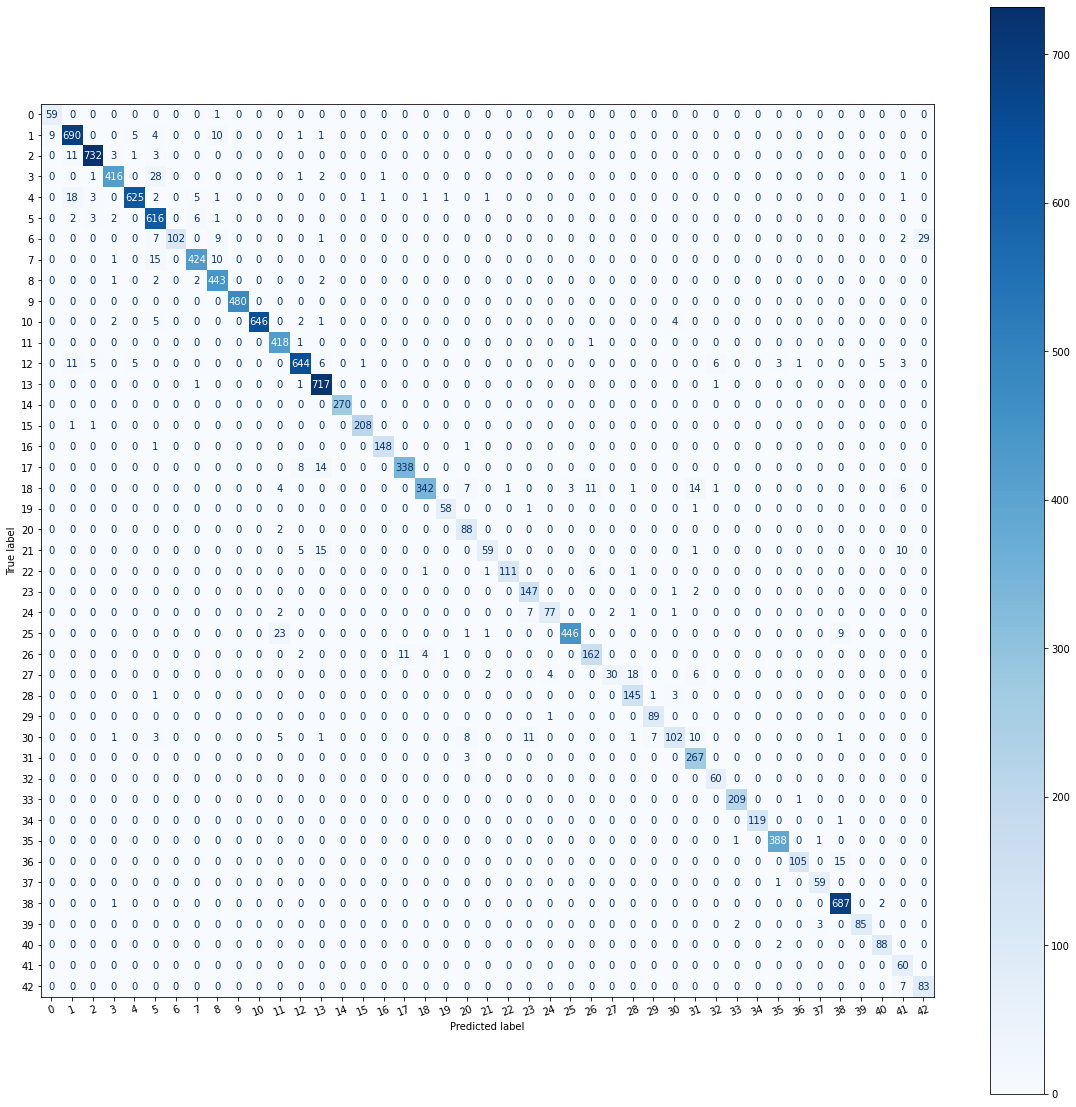

In [20]:
# Print confusion matrix

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, numClasses)
plot_confusion_matrix(labels_list, y_pred_list, labels_arr)

In [21]:
print(y_pred_list[:20])

[16, 1, 38, 33, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 20, 27, 38]


In [22]:
print(labels_list[:20])

[16, 1, 38, 33, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 20, 27, 38]


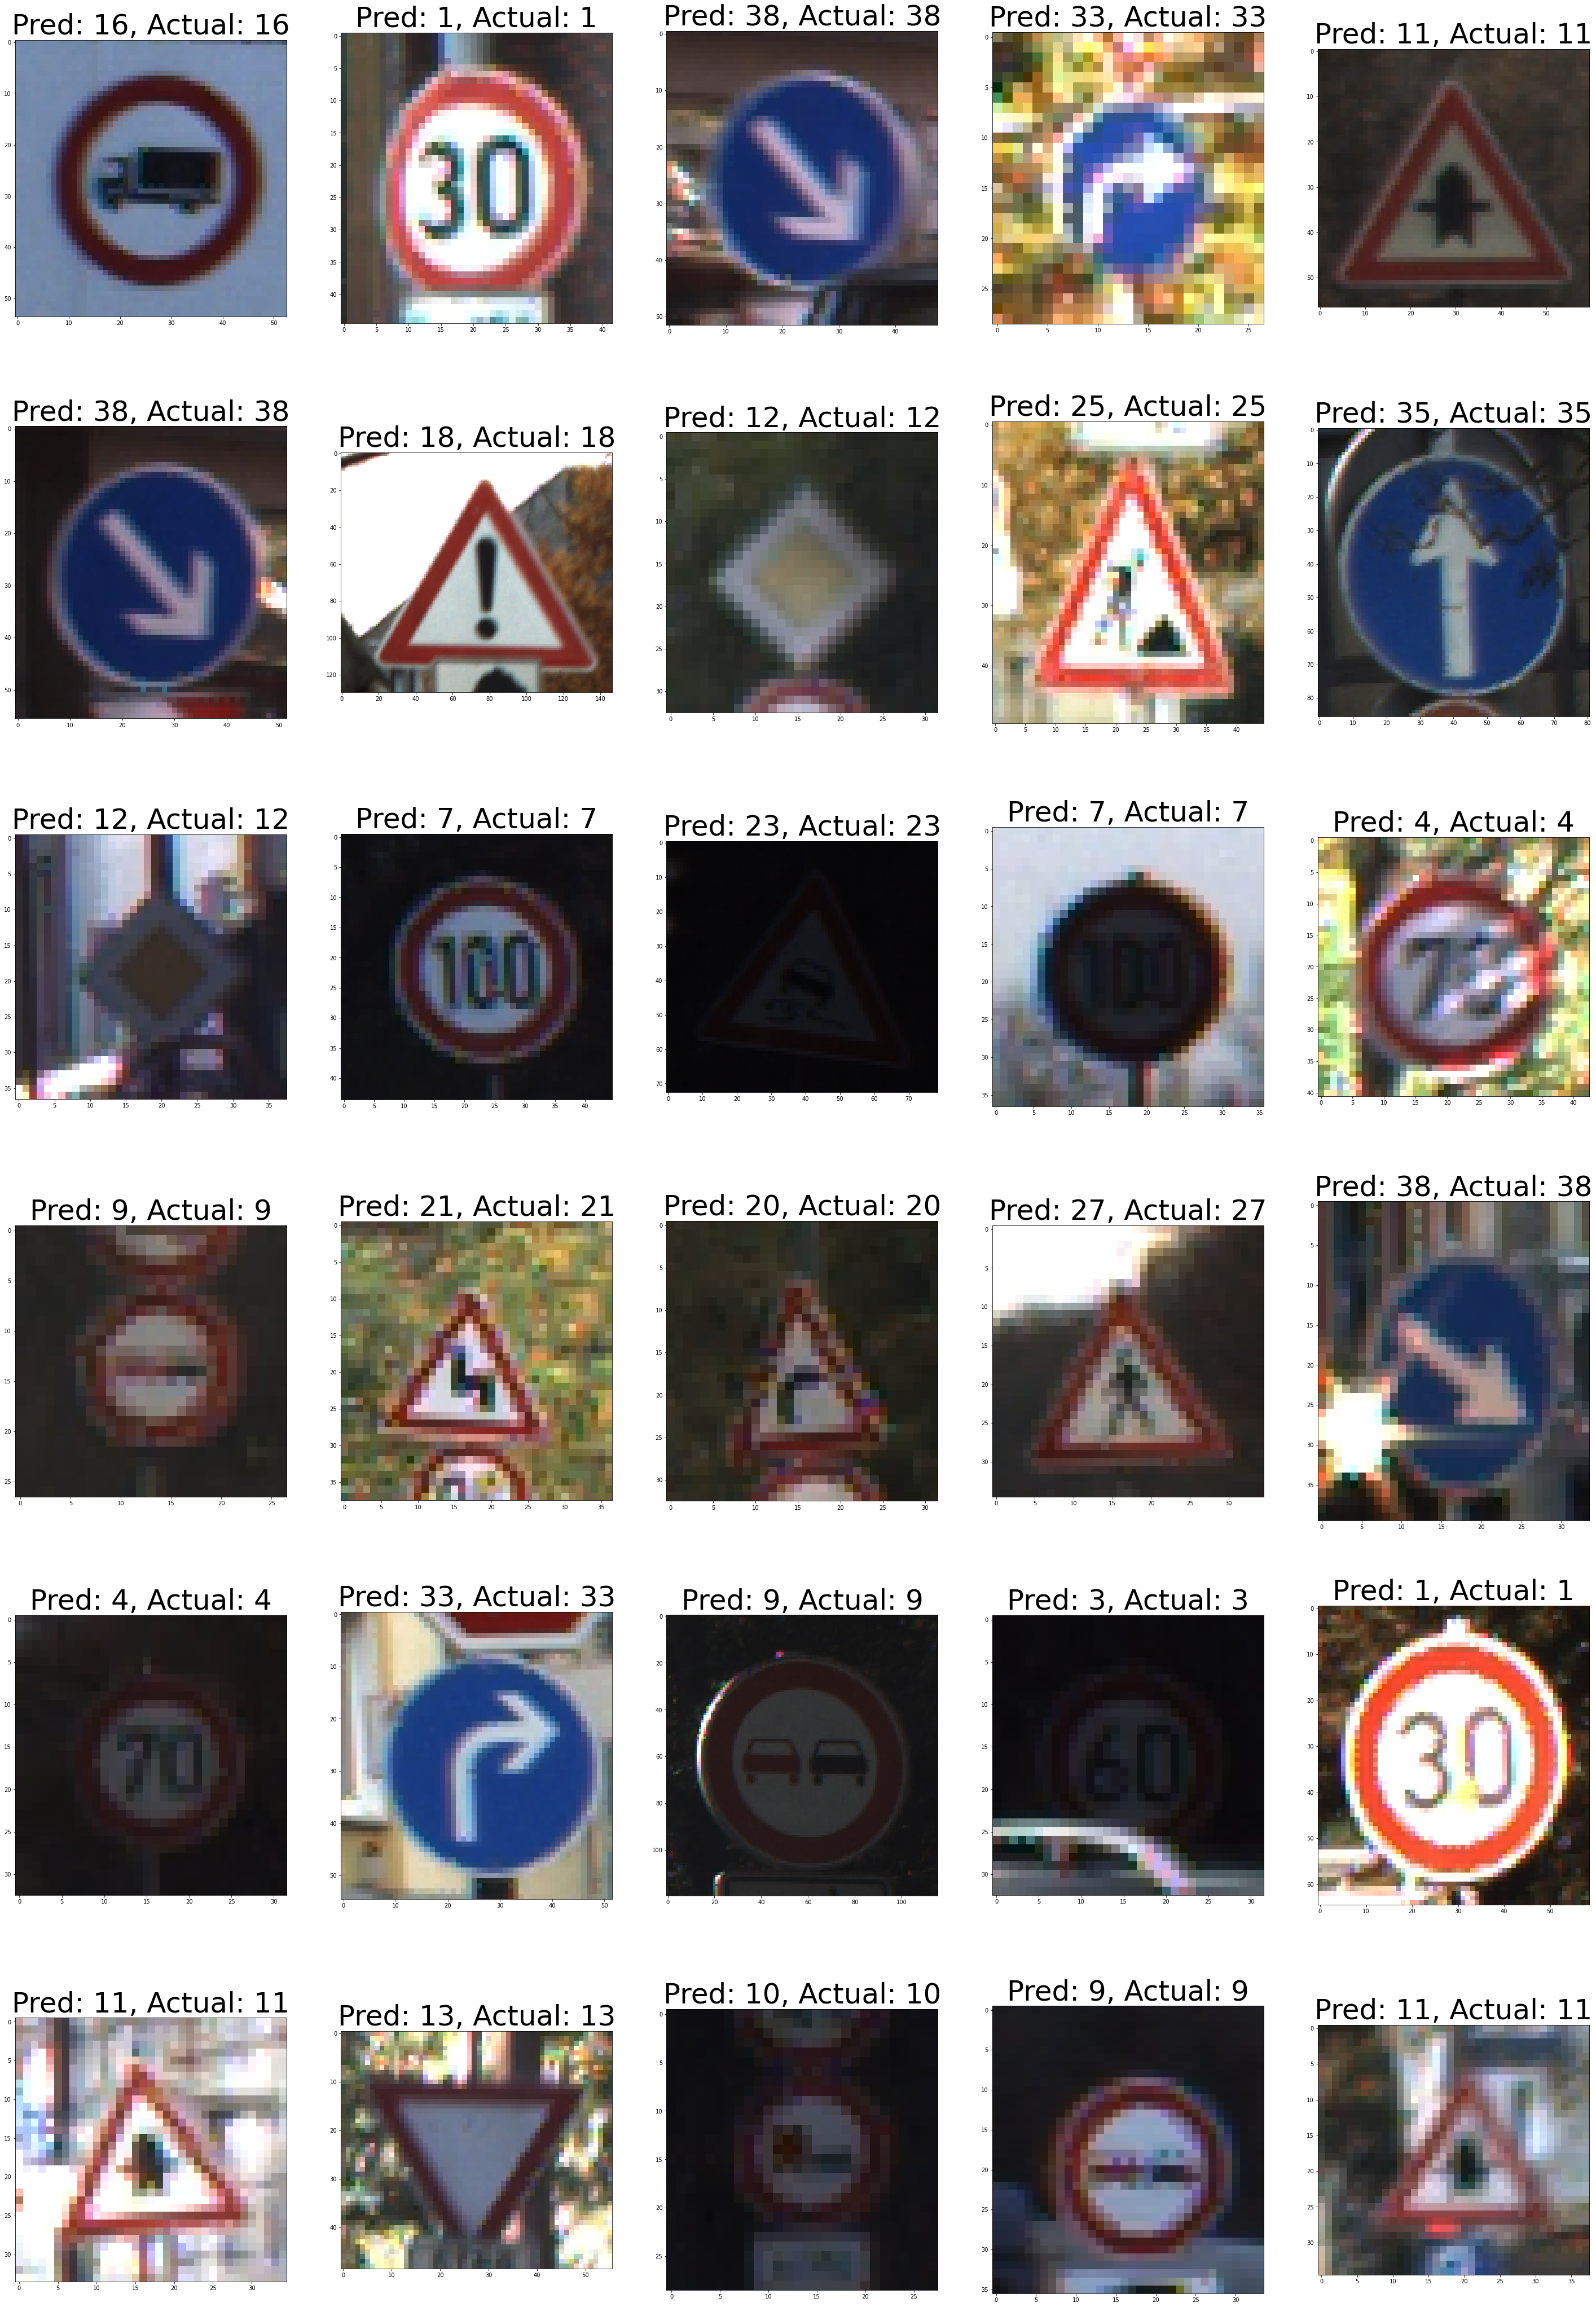

In [29]:
# Display first 30 images, along with the actual and predicted classes

fig, axs = plt.subplots(6,5,figsize=(50,75))
#fig.tight_layout(h_pad = 50)
for i in range(30):
    row = i // 5
    col = i % 5
    
#     imgName = '../GTSRB/Test/' + df.iloc[i].Path
    imgName = '../GTSRB/Test/gtsrb/GTSRB/Final_Test/Images/' + df.iloc[i].Filename
    img = Image.open(imgName)
    axs[row, col].imshow(img)
    title = "Pred: %d, Actual: %d" % (y_pred_list[i], labels_list[i])
    axs[row, col].set_title(title, fontsize=50)

plt.savefig("predictions.png", bbox_inches = 'tight', pad_inches=0.5)